In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/HDA*.py
!cat '/content/gdrive/My Drive/Colab Notebooks/HDA/utils_ds.py'
!cat '/content/gdrive/My Drive/Colab Notebooks/HDA/utils.py'
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/HDA')

path = '/content/gdrive/My Drive/Colab Notebooks/HDA'

import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom

import utils_ds
from utils import ModelSaveCallback, create_masked_ds, extract_maskedimage, scaling01, var_of_laplacian, rgb2gray

Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/HDA*.py': No such file or directory
import numpy as np
import h5py
import tensorflow as tf
import os
import pandas as pd
from PIL import Image


def load_dataset(filename):
    hf = h5py.File(filename, "r")
    dataset_orig = hf["dataset"][:]
    labels_orig = hf["labels"][:]
    classes_orig = hf["classes"][:]
    
    return dataset_orig, labels_orig, classes_orig

def load_dataset_tvt(filename):
    hf = h5py.File(filename, "r")
    train = hf["train"][:]
    labels_train = hf["labels_train"][:]
    valid = hf["valid"][:]
    labels_valid = hf["labels_valid"][:]
    test = hf["test"][:]
    labels_test = hf["labels_test"][:]
    
    return train, labels_train, valid, labels_valid, test, labels_test


def save_ds_h5(filename, dataset, labels, classes):
    hf = h5py.File(filename, 'w')
    hf.create_dataset('dataset', data=dataset)
    hf.create_dataset('labels', data=labels)
    hf.create_dataset

In [2]:
filename = 'lsc_TVT_RGB_NOartifacts_patchNOover260.h5'
x_train, y_train, x_valid, y_valid, x_test, y_test = utils_ds.load_dataset_tvt(path+'/datasets/'+filename)
print(path+'/datasets/'+filename)

/content/gdrive/My Drive/Colab Notebooks/HDA/datasets/lsc_TVT_RGB_NOartifacts_patchNOover260.h5


In [3]:
labels_train = utils_ds.convert_to_one_hot(np.array(y_train), 3).T 
labels_valid = utils_ds.convert_to_one_hot(np.array(y_valid), 3).T
labels_test = utils_ds.convert_to_one_hot(np.array(y_test), 3).T

train_length = y_train.shape[0]
valid_length = y_valid.shape[0]
test_length = y_test.shape[0]

batch_size = 32

img_shape = x_train[0].shape # (260, 260, 3)

train_steps = int(np.ceil(train_length/batch_size))
valid_steps = int(np.ceil(valid_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

In [4]:
tf_train = utils_ds.create_tf_dataset(x_train, labels_train, batch_size, normalize=False, shuffle=True, repeat=False, cache_file=False)
tf_valid = utils_ds.create_tf_dataset(x_valid, labels_valid, batch_size, normalize=False, shuffle=False, repeat=False, cache_file=False)

print(tf.data.experimental.cardinality(tf_train)); print(tf_train)
print(tf.data.experimental.cardinality(tf_valid)); print(tf_valid)

tf.Tensor(140, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
tf.Tensor(47, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>


# Our architecture

<img src="images/proposed_resnet.png" style="width:800px;height:300px;">

<img src="images/blocks.png" style="width:400px;height:350px;">



In [6]:
def ResBlock(x, kernelsize, filters):
    fx = tf.keras.layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = tf.keras.layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

def our_nn(input_shape):

    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.Conv2D(32, (1,1), (1,1), padding = 'same', activation = None)(X_input)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 32)
    X = ResBlock(X, kernelsize=(1, 1), filters = 32)
    X = tf.keras.layers.MaxPooling2D((2,2), strides = (2,2), padding = 'same')(X)

    X = tf.keras.layers.Conv2D(64, (1,1), (1,1), padding = 'same', activation = None)(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 64)
    X = ResBlock(X, kernelsize=(1, 1), filters = 64)
    X = tf.keras.layers.MaxPooling2D((2,2), strides = (2,2), padding = 'same')(X)

    X = tf.keras.layers.Conv2D(128, (1,1), (1,1), padding = 'same', activation = None)(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 128)
    X = ResBlock(X, kernelsize=(1, 1), filters = 128)
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    X = tf.keras.layers.Dense(3, activation = 'softmax')(X)
                                    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='our_nn') 

    return model


In [7]:
my_model = our_nn(img_shape)
my_model.summary()

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 260, 260, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 260, 260, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                            

In [8]:
epochs = 25
prova = '_' + my_model.name
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=56*40, decay_rate=.0001) # 1e-03 to 1e-7
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+prova+'.h5'
saving = ModelSaveCallback(savename)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [9]:
history_curr = my_model.fit(tf_train, epochs=epochs, verbose='auto', validation_data=tf_valid, callbacks=[saving])
np.save(savename[:-3]+'_history.npy',history_curr.history)

Epoch 1/25
  6/140 [>.............................] - ETA: 1:01 - loss: 1.0285 - accuracy: 0.5365

140/140 [==============================] - 91s 537ms/step - loss: 0.5262 - accuracy: 0.7748 - val_loss: 1.3321 - val_accuracy: 0.4113
Epoch 2/25
140/140 [==============================] - 74s 531ms/step - loss: 0.2776 - accuracy: 0.8951 - val_loss: 0.5961 - val_accuracy: 0.7393
Epoch 3/25
140/140 [==============================] - 75s 535ms/step - loss: 0.1872 - accuracy: 0.9355 - val_loss: 0.2591 - val_accuracy: 0.9007
Epoch 4/25
140/140 [==============================] - 75s 537ms/step - loss: 0.1587 - accuracy: 0.9511 - val_loss: 0.1723 - val_accuracy: 0.9400
Epoch 5/25
140/140 [==============================] - 75s 538ms/step - loss: 0.1359 - accuracy: 0.9574 - val_loss: 0.1197 - val_accuracy: 0.9607
Epoch 6/25
140/140 [==============================] - 76s 541ms/step - loss: 0.1259 - accuracy: 0.9667 - val_loss: 0.1295 - val_accuracy: 0.9620
Epoch 7/25
140/140 [==============================] - 76s 539ms/step - loss: 0.1302 - accuracy: 0.9600 - val_loss: 0.1025 - val_accuracy: 0.9

training accuracy = 0.9593750238418579
validation accuracy = 0.9679999947547913


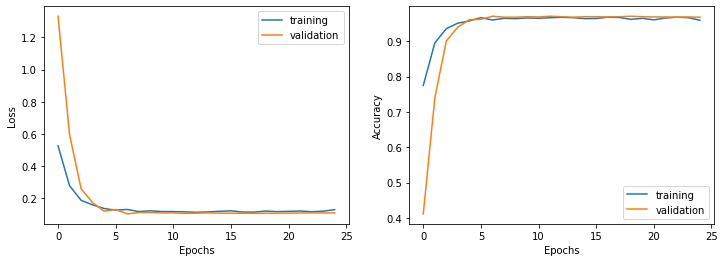

In [10]:
history = history_curr
plt.figure(figsize=(12,4))
plt.subplot(121); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.subplot(122); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.savefig(savename[:-3]+'.png')

# training performance
train_accuracy = history.history['accuracy'][-1]
print('training accuracy = ' + str(train_accuracy))

# validation preformance
valid_accuracy = history.history['val_accuracy'][-1]
print('validation accuracy = ' + str(valid_accuracy))

# Heatmap

In [12]:
import cv2
from PIL import Image

def heatmap_on_image(input_img,heatmap,threshold=0.6):
    heatmap = scaling01(heatmap)
    plt.figure(figsize=(14,12))
    plt.subplot(131); plt.imshow(input_img); plt.title('Original image'); plt.axis('off')
    plt.subplot(132); plt.imshow(heatmap,cmap='jet'); plt.title('Heatmap'); plt.axis('off')
    axes = plt.subplot(133); 
    axes.imshow(Image.fromarray(input_img.astype(np.uint8)).convert('L'), cmap='gray'); plt.title('Overlaid image')
    axes.imshow(heatmap, alpha = 0.3, cmap='jet', interpolation='bilinear'); plt.axis('off')

def getCAM(conv,pred,w,scale):
    target = np.argmax(pred).squeeze()
    weights = w[:, target].numpy()
    heatmap = conv.squeeze() @ weights
    heatmap = zoom(heatmap, zoom=(scale, scale))
    return scaling01(heatmap)

In [13]:
scale = img_shape[0]/140
w, b = my_model.get_layer("dense").weights
model_heatmap = keras.Model(inputs=my_model.input, outputs=[my_model.layers[-3].output, my_model.layers[-1].output], name='model_heatmap')

In [14]:
model_heatmap.summary()

Model: "model_heatmap"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 260, 260, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 260, 260, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                     

1/1 [==============================] - 0s 17ms/step


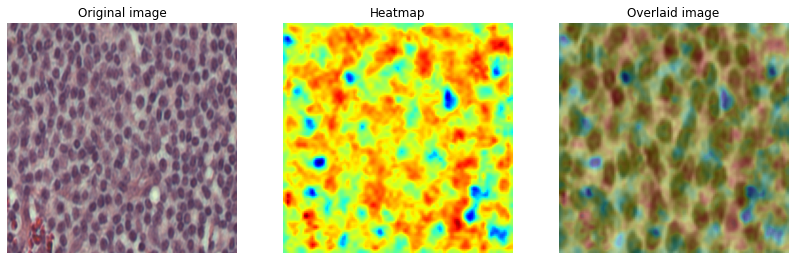

In [20]:
img_train = x_train[6]
conv, pred = model_heatmap.predict(np.expand_dims(img_train,axis=0))
heatmap = getCAM(conv,pred,w,scale)
heatmap_on_image(img_train,heatmap)
#plt.savefig(savename[:-3]+'heatmap.png')

In [21]:
my_model.evaluate(x_train,labels_train)

140/140 [==============================] - 21s 147ms/step - loss: 0.0552 - accuracy: 0.9908


[0.05515319108963013, 0.9908482432365417]

In [22]:
my_model.evaluate(x_valid,labels_valid)

47/47 [==============================] - 7s 145ms/step - loss: 0.1088 - accuracy: 0.9680


[0.10884024202823639, 0.9679999947547913]

In [23]:
my_model.evaluate(x_test,labels_test)

47/47 [==============================] - 7s 144ms/step - loss: 0.3093 - accuracy: 0.9053


[0.3093084990978241, 0.9053333401679993]

# Voting

In [24]:
def sum_prob_labels(pred_prob,n_subimages):
    # sum the probabilities for each labels
    pred_labels_sum = []
    pred_sum_prob = []
    pred_for_each = []
    for k in range(0,round(pred_prob.shape[0]/n_subimages)):
        pred_sum_prob.append(sum(pred_prob[k*n_subimages:(k+1)*n_subimages]))
        pred_labels_sum.append(pred_sum_prob[k].argmax())
        pred_for_each.append(pred_prob[k*n_subimages:(k+1)*n_subimages])
    return np.array(pred_labels_sum), np.array(pred_sum_prob), np.array(pred_for_each)

def voting(pred_prob,n_subimages):
    # by voting
    pred_labels_vot = []
    pred_voting = []
    for k in range(0,round(pred_prob.shape[0]/n_subimages)):
        v = pred_prob[k*n_subimages:(k+1)*n_subimages]
        voting = np.array([0,0,0]);
        for kk in range(0,n_subimages):
            voting[v[kk].argmax()]+=1
        pred_voting.append(voting)
        pred_labels_vot.append(voting.argmax())
    return np.array(pred_labels_vot), np.array(pred_voting)

In [48]:
filename = 'lsc_TVT_RGB_NOartifacts_resize224.h5'
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = utils_ds.load_dataset_tvt(path+'/datasets/'+filename)

In [49]:
pred_prob_train = my_model.predict(x_train)
pred_labels_sum, pred_sum_prob, pred_for_each = sum_prob_labels(pred_prob_train,20)
pred_labels_vot, pred_voting = voting(pred_prob_train,20)
acc_final_sum = sum(np.array(pred_labels_sum)==Y_train)/Y_train.shape
print('final accuracy for the sum of probabilities is:',acc_final_sum)
acc_final_vot = sum(np.array(pred_labels_vot)==Y_train)/Y_train.shape
print('final accuracy for the patches vote is:',acc_final_vot)

final accuracy for the sum of probabilities is: [1.]
final accuracy for the patches vote is: [1.]


In [50]:
pred_prob_valid = my_model.predict(x_valid)
pred_labels_sum, pred_sum_prob, pred_for_each = sum_prob_labels(pred_prob_valid,20)
pred_labels_vot, pred_voting = voting(pred_prob_valid,20)
acc_final_sum = sum(np.array(pred_labels_sum)==Y_valid)/Y_valid.shape
print('final accuracy for the sum of probabilities is:',acc_final_sum)
acc_final_vot = sum(np.array(pred_labels_vot)==Y_valid)/Y_valid.shape
print('final accuracy for the patches vote is:',acc_final_vot)
ind_miss_valid = np.arange(0,75)[np.array(pred_labels_vot)!=Y_valid]; print(ind_miss_valid)

47/47 [==============================] - 7s 144ms/step
final accuracy for the sum of probabilities is: [0.98666667]
final accuracy for the patches vote is: [0.98666667]
[30]


In [51]:
pred_prob_test = my_model.predict(x_test)
pred_labels_sum, pred_sum_prob, pred_for_each = sum_prob_labels(pred_prob_test,20)
pred_labels_vot, pred_voting = voting(pred_prob_test,20)
acc_final_sum = sum(np.array(pred_labels_sum)==Y_test)/Y_test.shape
print('final accuracy for the sum of probabilities is:',acc_final_sum)
acc_final_vot = sum(np.array(pred_labels_vot)==Y_test)/Y_test.shape
print('final accuracy for the patches vote is:',acc_final_vot)
ind_miss_test = np.arange(0,75)[np.array(pred_labels_vot)!=Y_test]; print(ind_miss_test)

47/47 [==============================] - 7s 143ms/step
final accuracy for the sum of probabilities is: [0.92]
final accuracy for the patches vote is: [0.92]
[ 4 36 45 46 48 68]
